In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers

import sys
from collections import Counter 
import pprint 
import math
import argparse 
import os
import collections
import json
import re
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import time 
import pandas as pd
import itertools
from ast import literal_eval

# funtions to handle labels
from utils.handle_labels import get_tag_counts_and_labels
from utils.handle_labels import drop_labels
from utils.handle_labels import group_labels_new
from utils.handle_labels import categories_count
from utils.handle_labels import get_imbalance
from utils.handle_labels import label_distribution
from utils.handle_labels import number_of_labels
#from utils.message_preprocess import message_processing
from utils.prepocess_code_change import parse_json, preprocess_roots, actions2sentence,expand_list,permutate_files
from utils.prepocess_code_change import get_seqlength,plot_hist,get_file_threshold,concat_files_to_sentence
from utils.plot_utils import pie_plot
from utils.embedding_utils import load_embedding

np.random.seed(0)

Using TensorFlow backend.


### Data Preparation

#### processing labels

(1922, 28)
<class 'list'>
['Testing', 'Bug fix']
Maintenance : 891
Feature Add : 330
Bug fix : 266
Documentation : 237
Clean up : 192
Refactoring : 111
Indentation : 48
Token Replace : 40
Source Control : 30
Cross : 24
Legal : 18
Debug : 10
Module Remove : 6
Module Move : 5
Rename : 5
Versioning : 4
Merge : 3
Initialization : 2
Internationalization : 1
Data : 1
Module Add : 1
1    1625
2     226
3      35
4       7
5       3
dtype: int64


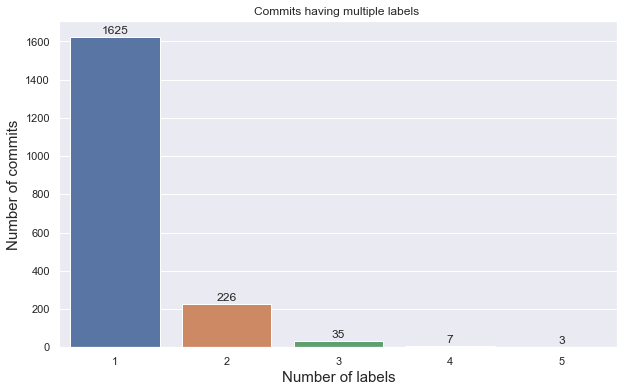

Corrective : 266
Adaptive : 237
Perfective : 1093
Implementation : 330
Non_functional : 70
Other : 34
Corrective : 266
Adaptive : 237
Perfective : 1093
Implementation : 330
1    1616
2     136
0     132
3      10
4       2
dtype: int64


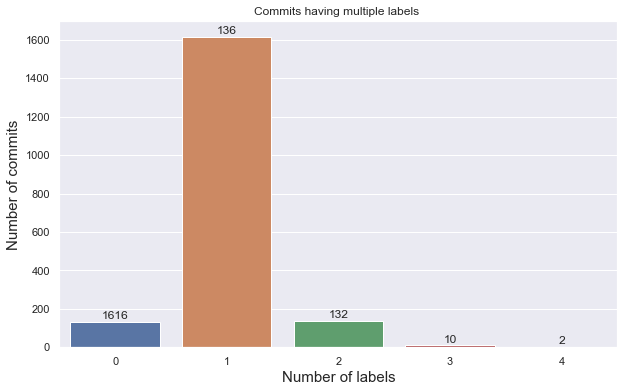

current number of samples: 1896
number of samples after drop:1616


In [2]:
# read data
df = pd.read_csv('data/commit_data_new.csv')
print(df.shape)

df['categories'] = df['categories'].apply(lambda x: literal_eval(x))
print(type(df['categories'].values[0]))
print(df['categories'].values[0])
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

# drop testing and build
new_df = drop_labels(df, ['Testing', 'Build'])
_ , target_col = get_tag_counts_and_labels(new_df)
multi_count = number_of_labels(new_df, target_col)

# merge some of categories
new_df = group_labels_new(new_df, ['Bug fix'], 'Corrective')
new_df = group_labels_new(new_df, ['Documentation'], 'Adaptive')
new_df = group_labels_new(new_df, ['Clean up', 'Maintenance','Refactoring'], 'Perfective')
new_df = group_labels_new(new_df, ['Feature Add'], 'Implementation')
new_df = group_labels_new(new_df, ['Legal', 'Module Remove','Rename','Token Replace','Merge'], 'Non_functional')
new_df = group_labels_new(new_df, ['Cross','Debug'], 'Other')

target_col = ['Corrective','Adaptive','Perfective','Implementation','Non_functional','Other']
multi_count = categories_count(new_df, target_col)

# Drop 'Non-functional' and 'Other'
new_df = new_df.drop(['Non_functional','Other'],axis = 1)

target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = categories_count(new_df, target_col)

# Drop rows with multiple labels
target_col = ['Corrective','Adaptive','Perfective','Implementation']
multi_count = number_of_labels(new_df, target_col)

print('current number of samples: %d'%new_df.shape[0])
new_df['label_sum'] = new_df[target_col].sum(axis=1)
new_df = new_df[new_df['label_sum']==1].reset_index(drop=True)
print('number of samples after drop:%d'%new_df.shape[0])
new_df = new_df.drop(['label_sum'], axis = 1)

# Drop target col
new_df = new_df[new_df['Corrective']!=1].reset_index(drop=True)
target_col = ['Adaptive','Perfective','Implementation']

#### Read code change data

In [3]:
# generate file name for search
csha = new_df['Commit ID'].values
files = [c + '.json' for c in csha]
application_name = new_df['project name'].values
files_path = []
for project_name, c in zip(application_name,files):
    files_path.append(project_name + '_' + c)
print(files_path[0])

# get code change data
files = files_path
folder_path = 'D:\\Research\\AllFiles_Research\\'
all_files, csha = parse_json(folder_path, files)

# preprocess_roots
dic, datas, freq_dict = preprocess_roots(all_files)
rev_dic = dict(zip(dic.values(), dic.keys()))
print(len(dic))

# concat action to sentence
training_data = actions2sentence(datas)

apache-avro_2df0775d2f368b326e3ac6442ce4850e3fe62edc.json
472


#### Permutate and get train data

In [4]:
# merge csha and training data to a dataframe
commits_df = pd.DataFrame(data = [csha, training_data]).T
commits_df.columns = ["Commit ID", "Files"]
print(new_df.shape)

# merge two dataframe and drop some of labels
commits_labels_df = pd.merge(commits_df, new_df, on='Commit ID')

# split dataframe to train and test
msk = np.random.rand(len(commits_labels_df)) < 0.8
train_df = commits_labels_df[msk]
test_df = commits_labels_df[~msk]

# permutate train_df
permutate_train_dic = permutate_files(train_df['Commit ID'],train_df['Files'])
permutate_train_df = pd.DataFrame(list(permutate_train_dic.items()))
permutate_train_df.columns = ['Commit ID','Files']
train_df = train_df.drop(["Files"], axis=1)
train_df['Files'] = permutate_train_df['Files'].values

# expanded train_df list
expanded_train_df = expand_list(train_df)

print('exp_train_df shape:',expanded_train_df.shape)
print('train_df shape:',train_df.shape)
print('test_df shape:',test_df.shape)

(1389, 29)
exp_train_df shape: (6973, 30)
train_df shape: (955, 30)
test_df shape: (245, 30)


#### Determine File Threshold

INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_VariableDeclarationStatement_Block INS_EnhancedForStatement_Block
<sample training data>:  ['INS_ImportDeclaration_CompilationUnit INS_ImportDeclaration_CompilationUnit INS_VariableDeclarationStatement_Block INS_EnhancedForStatement_Block']
max length: 1656
length threshold 42
Index(['Commit ID', 'project name', 'commit_message', 'Maintenance',
       'Feature Add', 'Bug fix', 'Documentation', 'Clean up', 'Refactoring',
       'Indentation', 'Token Replace', 'Source Control', 'Cross', 'Legal',
       'Debug', 'Module Remove', 'Module Move', 'Rename', 'Versioning',
       'Merge', 'Initialization', 'Internationalization', 'Data', 'Module Add',
       'categories', 'Corrective', 'Adaptive', 'Perfective', 'Implementation',
       'Files', 'len_seq'],
      dtype='object')


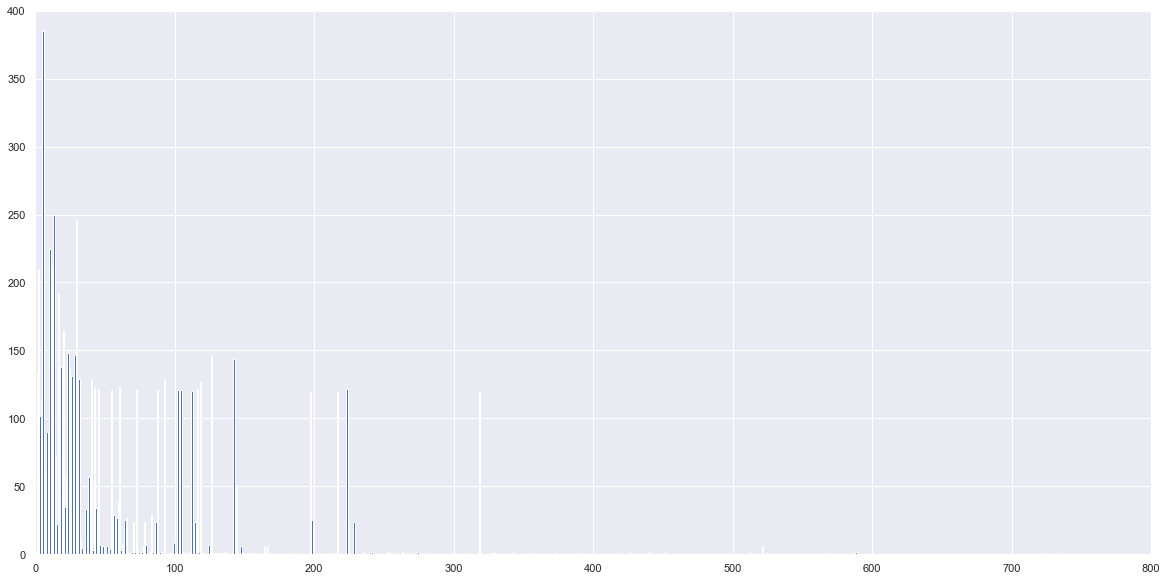

In [5]:
# concat file to sentences
concat_train_data = concat_files_to_sentence(expanded_train_df["Files"])
concat_test_data = concat_files_to_sentence(test_df["Files"])
print(concat_train_data[1])

# plot distribution
max_seqlength, sequence_list = get_seqlength(concat_train_data)
print("<sample training data>: ", training_data[1])
print('max length: %d'%max_seqlength)
plot_hist(sequence_list)

# getting file threshold
threshold = 0.6
number_of_actions = [len(item.split()) for item in concat_train_data]
length_threshold = get_file_threshold(number_of_actions, threshold)
print("length threshold %d"%length_threshold)

# filter data
expanded_train_df = expanded_train_df.drop(["Files"], axis=1)
test_df = test_df.drop(["Files"], axis=1)
expanded_train_df["Files"] = concat_train_data 
test_df["Files"] = concat_test_data 

# filter too long commits
expanded_train_df['len_seq'] = expanded_train_df.apply(lambda row: len(row['Files'].split()), axis = 1)
test_df['len_seq'] = test_df.apply(lambda row: len(row['Files'].split()), axis = 1)
expanded_train_df = expanded_train_df[expanded_train_df['len_seq'] <= length_threshold].reset_index(drop = True)
test_df = test_df[test_df['len_seq'] <= length_threshold].reset_index(drop = True)
print(test_df.columns)

In [6]:
expanded_train_df['len_seq'] = expanded_train_df.apply(lambda row: len(row['Files'].strip()), axis = 1)
test_df['len_seq'] = test_df.apply(lambda row: len(row['Files'].strip()), axis = 1)
expanded_train_df = expanded_train_df[expanded_train_df['len_seq'] != 0].reset_index(drop = True)
test_df = test_df[test_df['len_seq'] != 0].reset_index(drop = True)

####  Tokenize and Pad data and get embedding

In [7]:
# padding data
train_test_split_number = expanded_train_df.shape[0]
print(expanded_train_df.shape)
df_for_tokenize = pd.concat([expanded_train_df,test_df], axis = 0)
print(df_for_tokenize.shape)

#Training 
docs = df_for_tokenize['Files'].values
t = Tokenizer(filters = '', lower=False)
t.fit_on_texts(docs)

sequences = t.texts_to_sequences(docs)
print(sequences[0])

#Pad training data 
padded_seq = pad_sequences(sequences, maxlen=length_threshold + 1, padding="post", truncating="post")
print(padded_seq.shape)

vocabulary = t.word_index 
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"
print('length of vocabulary:%d'%len(vocabulary_inv.keys()))

# split train and test set
X_train = padded_seq[0:train_test_split_number]
X_test = padded_seq[train_test_split_number:]

target_col =  ['Adaptive','Perfective','Implementation']
y_train = expanded_train_df[target_col].values
y_test = test_df[target_col].values

print(X_train[10, :])
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# get embedding
pre_embed = load_embedding("embedding_genism_64_dic.txt")

embedding_weights = dict()
for key in range(0, len(vocabulary_inv.keys())):
    embedding_weights[key] = pre_embed[vocabulary_inv[key]]

# X_train = np.stack([np.stack([pre_embed[vocabulary_inv_train[action]] for action in commit]) for commit in X_train])
# X_test = np.stack([np.stack([pre_embed[vocabulary_inv_test[action]] for action in commit]) for commit in X_test])
# print("x_train static shape:", X_train.shape)
# print("x_test static shape:", X_test.shape)

(4165, 31)
(4355, 31)
[2, 2, 17, 121]
(4355, 43)
length of vocabulary:338
[1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
(4165, 43)
(190, 43)
(4165, 3)
(190, 3)


### CNN for text pytorch

### RNN for text classification

In [91]:
import os
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader
#from model.GRU import SimpleGRU
from train_model import train, eval, print_evaluation_scores
from dataloader import CodeChangeDataset, ToTensor

In [147]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RCNN(nn.Module):
    def __init__(self, args):
        super(RCNN, self).__init__()
        
        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        output_size : 2 = (pos, neg)
        hidden_sie : Size of the hidden_state of the LSTM
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embedding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
        """
        self.output_size = args.n_out
        self.hidden_size = args.n_hidden
        self.vocab_size = args.vocab_size
        self.embedding_dim = args.embedding_dim
        
        self.word_embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)            # Initializing the look-up table.
        # self.word_embeddings.weight = nn.Parameter(args.weights, requires_grad=False) # Assigning the look-up table to the pre-trained GloVe word embedding.
        self.dropout = 0.2
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_size, dropout=0, bidirectional=True)
        self.W2 = nn.Linear(2* self.hidden_size+self.embedding_dim, self.hidden_size)
        self.label = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_sentence):
    
        """ 
        Parameters
        ----------
        input_sentence: input_sentence of shape = (batch_size, num_sequences)
        batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)
        
        Returns
        -------
        Output of the linear layer containing logits for positive & negative class which receives its input as the final_hidden_state of the LSTM
        final_output.shape = (batch_size, output_size)
        """
        
        """
        The idea of the paper "Recurrent Convolutional Neural Networks for Text Classification" is that we pass the embedding vector
        of the text sequences through a bidirectional LSTM and then for each sequence, our final embedding vector is the concatenation of 
        its own GloVe embedding and the left and right contextual embedding which in bidirectional LSTM is same as the corresponding hidden
        state. This final embedding is passed through a linear layer which maps this long concatenated encoding vector back to the hidden_size
        vector. After this step, we use a max pooling layer across all sequences of texts. This converts any varying length text into a fixed
        dimension tensor of size (batch_size, hidden_size) and finally we map this to the output layer.
        """
        
        input = self.word_embeddings(input_sentence) # embedded input of shape = (num_sequences, batch_size, embedding_length)
        input = input.permute(1, 0, 2) # input.size() = (num_sequences, batch_size, embedding_length)
        h_0, c_0 = self.init_hidden(input_sentence.size(0))

        output, (final_hidden_state, final_cell_state) = self.lstm(input, (h_0, c_0))
        
        final_encoding = torch.cat((output, input), 2).permute(1, 0, 2)
        y = self.W2(final_encoding) # y.size() = (batch_size, num_sequences, hidden_size)
        y = F.max_pool1d(y, y.size()[2]) # y.size() = (batch_size, hidden_size, 1)
        y = y.squeeze(2)
        outp = self.label(y)
        
        return F.log_softmax(outp, dim=-1)

    def init_hidden(self, batch_size):
        h = Variable(torch.zeros((2, batch_size, self.hidden_size),device=torch.device("cuda")))
        c = Variable(torch.zeros((2, batch_size, self.hidden_size),device=torch.device("cuda")))
        return h,c

In [148]:
class Args:
     def __init__(self):
        self.vocab_size = None
        self.embedding_dim = None
        self.n_hidden = None
        self.n_out = None
        self.num_layers = None
        self.lr = None
        self.batch_size = None
        self.cude = None
        self.epochs = None
        self.embed_weights = None
        self.device = None

In [149]:
def main():
    # REPRODUCIBILITY
    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(0)
    
    vocab_size = len(vocabulary_inv.keys())
    args = Args()
    
    # Parameters
    args.vocab_size = vocab_size 
    args.embedding_dim = 64 
    args.n_hidden = 300 
    args.n_out = 3
    args.num_layers = 1
    args.lr = 0.001
    args.batch_size = 256
    args.cuda = True
    args.epochs = 50
    args.device = 0
    args.weights = torch.from_numpy(np.array([v for v in embedding_weights.values()])).float()
    
    # data loader
    train_data = CodeChangeDataset(X_train, y_train, transform = ToTensor())
    test_data = CodeChangeDataset(X_test, y_test, transform = ToTensor())

    train_dataloader = DataLoader(train_data, batch_size=args.batch_size,shuffle=True, num_workers=0)
    test_dataloader = DataLoader(test_data, batch_size=args.batch_size, shuffle = False, num_workers=0)

    # model
    model = RCNN(args)
    
    if args.cuda:
        torch.cuda.set_device(args.device)
        model = model.cuda()

    try:
        for epoch in range(args.epochs):
            train_loss, train_acc = train(train_dataloader, model, args, 'RCNN')
            val_loss, val_acc = eval(test_dataloader, model, args,'RCNN')
            print(f'Epoch: {epoch + 1:02} -- Train Loss: {train_loss:.3f} Train Acc: {train_acc:.2f}%    Val. Loss: {val_loss:3f} Val. Acc: {val_acc:.2f}%')
    
    except KeyboardInterrupt:
        print('\n' + '-' * 89)
        print('Exiting from training early')

if __name__ == '__main__':
    main()     

RuntimeError: size mismatch, m1: [256 x 43], m2: [300 x 3] at C:/w/1/s/windows/pytorch/aten/src\THC/generic/THCTensorMathBlas.cu:268